이미지 파일 경로: /SSD4/psleon/YOLOv11/data/Training/01_data/TS_사고유형-S63_DATA2_충돌-CN/S63_DATA2_CN_L1_D2023-09-14-10-30_001_000026.jpg
라벨 파일 경로: /SSD4/psleon/YOLOv11/data/Training/02_label/TL_사고유형-S63_DATA2_충돌-CN/S63_DATA2_CN_L1_D2023-09-14-10-30_001_000026.json

✅ 성공! 바운딩 박스가 그려진 이미지를 저장했습니다.
   -> 저장된 파일: /SSD4/psleon/YOLOv11/S63_DATA2_CN_L1_D2023-09-14-10-30_001_000026_bbox.jpg


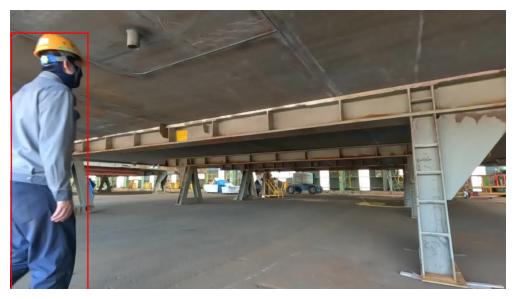

In [13]:
import json
from PIL import Image, ImageDraw
import os
import matplotlib.pyplot as plt

base_path = "/SSD4/psleon/YOLOv11/data/"
file_name = "S63_DATA2_CN_L1_D2023-09-14-10-30_001_000026"

image_path = os.path.join(base_path, f"Training/01_data/TS_사고유형-S63_DATA2_충돌-CN/{file_name}.jpg")
label_path = os.path.join(base_path, f"Training/02_label/TL_사고유형-S63_DATA2_충돌-CN/{file_name}.json")

output_path = f'./{file_name}_bbox.jpg'

print(f"이미지 파일 경로: {image_path}")
print(f"라벨 파일 경로: {label_path}")

try:
    # --- 2. Load Image and JSON Data ---
    img = Image.open(image_path)
    with open(label_path, 'r', encoding='utf-8') as f:
        label_data = json.load(f)

    # --- 3. Extract Bounding Box Information ---
    annotation = label_data['annotations'][0]
    bbox = annotation['bbox']

    # --- 4. Draw the Bounding Box ---
    draw = ImageDraw.Draw(img)
    x_min, y_min, width, height = bbox
    shape = [(x_min, y_min), (x_min + width, y_min + height)]
    draw.rectangle(shape, outline="red", width=5)

    # --- 5. Save the Result ---
    img.save(output_path)

    print(f"\n✅ 성공! 바운딩 박스가 그려진 이미지를 저장했습니다.")
    print(f"   -> 저장된 파일: {os.path.abspath(output_path)}")
    
    plt.imshow(img)
    plt.axis('off')
    plt.show()

except FileNotFoundError:
    print(f"\n❌ 오류: 파일을 찾을 수 없습니다.")
    print("   지정한 절대 경로에 파일이 실제로 존재하는지 다시 확인해주세요.")
    print("   터미널에서 'ls -l [파일 경로]' 명령으로 확인할 수 있습니다.")
except Exception as e:
    print(f"알 수 없는 오류가 발생했습니다: {e}")

In [17]:
 !ls data/Training/
 
!ls data/Training/01_data/
!ls data/Training/02_label/

01_data  02_label
TS_사고유형-S63_DATA2_충돌-CN  TS_사고유형-S63_DATA2_낙하-ON
TS_사고유형-S63_DATA2_충돌-CP  TS_사고유형-S63_DATA2_낙하-OP
TS_사고유형-S63_DATA2_추락-FN  TS_사고유형-S63_DATA2_화재-SN
TS_사고유형-S63_DATA2_추락-FP  TS_사고유형-S63_DATA2_화재-SP
TL_사고유형-S63_DATA2_충돌-CN  TL_사고유형-S63_DATA2_낙하-ON
TL_사고유형-S63_DATA2_충돌-CP  TL_사고유형-S63_DATA2_낙하-OP
TL_사고유형-S63_DATA2_추락-FN  TL_사고유형-S63_DATA2_화재-SN
TL_사고유형-S63_DATA2_추락-FP  TL_사고유형-S63_DATA2_화재-SP


In [25]:
import os
import json
import yaml
import shutil

def process_datasets_all_formats(base_path='data'):
    """
    Training과 Validation 데이터셋을 모두 스캔하여 클래스를 통합하고,
    각각에 대해 YOLO와 DETR(COCO) 형식의 라벨과 최종 설정 파일을 생성합니다.
    """
    splits = ['Training', 'Validation']
    yolo_output_root = os.path.join(base_path, '03_yolov11')
    detr_output_root = os.path.join(base_path, '04_DETR')

    # --- 초기화: 기존 출력 폴더가 있다면 삭제하고 새로 생성 ---
    for path in [yolo_output_root, detr_output_root]:
        if os.path.exists(path):
            shutil.rmtree(path)
        os.makedirs(path)

    print("=" * 60)
    print("YOLO & DETR 데이터셋 생성 통합 작업을 시작합니다 (Train/Val 분리).")
    print("=" * 60)

    # --- 1단계: Training과 Validation 모두를 스캔하여 고유 클래스 이름 수집 ---
    print("\n[1단계] 전체 데이터셋(Train+Val)에서 고유 클래스 이름을 수집합니다...")
    unique_class_names = set()
    for split in splits:
        label_root = os.path.join(base_path, split, '02_label')
        if not os.path.exists(label_root):
            print(f"  - {split} 라벨 폴더를 찾을 수 없습니다. 건너뜁니다: {label_root}")
            continue
        print(f"  - '{split}' 폴더 스캔 중...")
        for dirpath, _, filenames in os.walk(label_root):
            for filename in filenames:
                if filename.endswith('.json'):
                    try:
                        with open(os.path.join(dirpath, filename), 'r', encoding='utf-8') as f:
                            data = json.load(f)
                        for class_info in data.get('class', []):
                            if class_info.get('name'):
                                unique_class_names.add(class_info['name'])
                    except Exception:
                        pass
    
    if not unique_class_names:
        print("\n❌ 오류: 클래스 이름을 찾을 수 없어 작업을 중단합니다.")
        return

    # --- 2단계: 고유 클래스 이름에 새로운 통합 ID 부여 (마스터 키 생성) ---
    sorted_names = sorted(list(unique_class_names))
    class_name_to_id_map = {name: i for i, name in enumerate(sorted_names)}

    print("\n[2단계] 새로운 통합 클래스 ID 맵을 생성했습니다:")
    for name, new_id in class_name_to_id_map.items():
        print(f"  ID: {new_id} -> 이름: '{name}'")

    # --- 3단계: 각 데이터셋(Train/Val)을 개별적으로 처리 및 변환 ---
    all_coco_data = {}
    coco_categories = [{"id": i, "name": name, "supercategory": "object"} for name, i in class_name_to_id_map.items()]

    for split in splits:
        print(f"\n[3단계 - {split}] '{split}' 데이터셋 변환을 시작합니다...")
        label_root = os.path.join(base_path, split, '02_label')
        if not os.path.exists(label_root):
            continue

        coco_split_output = {
            "images": [],
            "annotations": [],
            "categories": coco_categories
        }
        image_id_counter = 0
        annotation_id_counter = 0
        converted_files = 0

        for dirpath, _, filenames in os.walk(label_root):
            for filename in filenames:
                if not filename.endswith('.json'):
                    continue
                
                json_path = os.path.join(dirpath, filename)
                try:
                    # ... (이하 파일 처리 로직은 이전과 동일) ...
                    with open(json_path, 'r', encoding='utf-8') as f:
                        data = json.load(f)

                    img_info = data.get('images', {})
                    img_filename_relative = os.path.join(os.path.basename(os.path.dirname(json_path)), img_info.get('file_name'))
                    img_width = img_info.get('width')
                    img_height = img_info.get('height')

                    if not all([img_filename_relative, img_width, img_height]):
                        continue

                    coco_split_output["images"].append({
                        "id": image_id_counter,
                        "file_name": img_filename_relative,
                        "width": img_width,
                        "height": img_height
                    })

                    local_id_to_name = {c['id']: c['name'] for c in data.get('class', [])}
                    yolo_lines = []

                    for ann in data.get('annotations', []):
                        original_class_id = ann.get('object_class')
                        bbox_coco_style = ann.get('bbox')
                        class_name = local_id_to_name.get(original_class_id)
                        
                        if not all([class_name, bbox_coco_style]): continue
                            
                        new_consistent_id = class_name_to_id_map[class_name]
                        x_min, y_min, x_max, y_max = bbox_coco_style

                        yolo_x_c, yolo_y_c, yolo_w, yolo_h = ((x_min + x_max) / 2) / img_width, ((y_min + y_max) / 2) / img_height, (x_max - x_min) / img_width, (y_max - y_min) / img_height
                        yolo_lines.append(f"{new_consistent_id} {yolo_x_c:.6f} {yolo_y_c:.6f} {yolo_w:.6f} {yolo_h:.6f}")
                        
                        coco_bbox_width, coco_bbox_height = x_max - x_min, y_max - y_min
                        coco_split_output["annotations"].append({
                            "id": annotation_id_counter, "image_id": image_id_counter,
                            "category_id": new_consistent_id,
                            "bbox": [x_min, y_min, coco_bbox_width, coco_bbox_height],
                            "area": coco_bbox_width * coco_bbox_height, "iscrowd": 0, "segmentation": []
                        })
                        annotation_id_counter += 1

                    relative_dir = os.path.relpath(dirpath, label_root)
                    yolo_output_dir = os.path.join(yolo_output_root, split, relative_dir)
                    os.makedirs(yolo_output_dir, exist_ok=True)
                    txt_filename = filename.replace('.json', '.txt')
                    with open(os.path.join(yolo_output_dir, txt_filename), 'w', encoding='utf-8') as out_f:
                        out_f.write("\n".join(yolo_lines))
                    
                    image_id_counter += 1
                    converted_files += 1
                except Exception as e:
                    print(f"  ❌ {json_path} 파일 처리 중 오류 발생: {e}")
        
        all_coco_data[split] = coco_split_output
        print(f"  -> '{split}' 데이터셋의 {converted_files}개 파일 변환 완료.")

    # --- 4단계: 최종 결과 파일들 저장 ---
    print("\n[4단계] 최종 결과 파일들을 디스크에 저장합니다...")

    # 4a: DETR/COCO JSON 파일들 저장 (training/validation 분리)
    for split_name, coco_data in all_coco_data.items():
        detr_filename = f"{split_name.lower()}_annotations.json"
        detr_json_path = os.path.join(detr_output_root, detr_filename)
        try:
            with open(detr_json_path, 'w', encoding='utf-8') as f:
                json.dump(coco_data, f, indent=4)
            print(f"  ✅ DETR '{split_name}' 저장 성공! -> {detr_json_path}")
        except Exception as e:
            print(f"  ❌ DETR '{split_name}' 저장 실패: {e}")

    # 4b: 최종 YOLO YAML 파일 저장 (train/val 경로 분리)
    data_yaml = {
        'path': os.path.abspath(base_path), # 데이터셋 루트 절대 경로
        'train': 'Training/01_data',        # 학습 이미지 폴더 상대 경로
        'val': 'Validation/01_data',      # 검증 이미지 폴더 상대 경로
        'nc': len(sorted_names),
        'names': sorted_names
    }
    yaml_output_path = os.path.join(base_path, 'dataset.yaml')
    try:
        with open(yaml_output_path, 'w', encoding='utf-8') as f:
            yaml.dump(data_yaml, f, allow_unicode=True, sort_keys=False)
        print(f"  ✅ YOLO 설정 파일 저장 성공! -> {yaml_output_path}")
    except Exception as e:
        print(f"  ❌ YAML 파일 저장 실패: {e}")

    print("\n" + "=" * 60)
    print("모든 작업이 완료되었습니다.")
    print("=" * 60)

# --- 스크립트 실행 ---
if __name__ == "__main__":
    process_datasets_all_formats(base_path='data')

YOLO & DETR 데이터셋 생성 통합 작업을 시작합니다 (Train/Val 분리).

[1단계] 전체 데이터셋(Train+Val)에서 고유 클래스 이름을 수집합니다...
  - 'Training' 폴더 스캔 중...
  - 'Validation' 폴더 스캔 중...

[2단계] 새로운 통합 클래스 ID 맵을 생성했습니다:
  ID: 0 -> 이름: '낙하작업자'
  ID: 1 -> 이름: '연기'
  ID: 2 -> 이름: '조선작업자'
  ID: 3 -> 이름: '추락작업자'
  ID: 4 -> 이름: '충돌작업자'

[3단계 - Training] 'Training' 데이터셋 변환을 시작합니다...
  -> 'Training' 데이터셋의 66660개 파일 변환 완료.

[3단계 - Validation] 'Validation' 데이터셋 변환을 시작합니다...
  -> 'Validation' 데이터셋의 8331개 파일 변환 완료.

[4단계] 최종 결과 파일들을 디스크에 저장합니다...
  ✅ DETR 'Training' 저장 성공! -> data/04_DETR/training_annotations.json
  ✅ DETR 'Validation' 저장 성공! -> data/04_DETR/validation_annotations.json
  ✅ YOLO 설정 파일 저장 성공! -> data/dataset.yaml

모든 작업이 완료되었습니다.


-  ID: 0 -> 이름: '낙하작업자'
-  ID: 1 -> 이름: '연기'
-  ID: 2 -> 이름: '조선작업자'
-  ID: 3 -> 이름: '추락작업자'
-  ID: 4 -> 이름: '충돌작업자'

In [24]:
!ls data/Validation/01_data/
!ls data/Validation/02_label/

VS_사고유형-S63_DATA2_충돌-CN  VS_사고유형-S63_DATA2_낙하-ON
VS_사고유형-S63_DATA2_충돌-CP  VS_사고유형-S63_DATA2_낙하-OP
VS_사고유형-S63_DATA2_추락-FN  VS_사고유형-S63_DATA2_화재-SN
VS_사고유형-S63_DATA2_추락-FP  VS_사고유형-S63_DATA2_화재-SP
VL_사고유형-S63_DATA2_충돌-CN  VL_사고유형-S63_DATA2_낙하-ON
VL_사고유형-S63_DATA2_충돌-CP  VL_사고유형-S63_DATA2_낙하-OP
VL_사고유형-S63_DATA2_추락-FN  VL_사고유형-S63_DATA2_화재-SN
VL_사고유형-S63_DATA2_추락-FP  VL_사고유형-S63_DATA2_화재-SP
